In [1]:
# Count "large" effect_size_magnitude pathways per CSV and per disease
# Designed for Jupyter/IPython. Saves two CSVs and prints summaries.

import os
from pathlib import Path
from typing import List, Dict, Optional
import pandas as pd

BASE_DIR = Path("/mnt/disk1/data_jin/Pathway_MAML/results/biomarker")  # <-- 수정 가능

def find_csvs(disease_dir: Path) -> List[Path]:
    """Prefer files named like significant_pathways*.csv, else fallback to any *.csv."""
    preferred = sorted(disease_dir.glob("significant_pathways*.csv"))
    if preferred:
        return preferred
    return sorted(disease_dir.glob("*.csv"))

def count_large_in_file(csv_path: Path) -> Dict[str, Optional[object]]:
    """Read a CSV and count rows where effect_size_magnitude == 'large' (case-insensitive)."""
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        return {
            "disease": csv_path.parent.name,
            "csv_file": str(csv_path),
            "large_count": None,
            "total_rows": None,
            "error": f"read_error: {e}",
        }

    # Column name normalization (case-insensitive, allow variants)
    cols_lower = {c.lower(): c for c in df.columns}
    key = None
    for cand in ("effect_size_magnitude", "effectsize_magnitude", "effect_size_label", "magnitude"):
        if cand in cols_lower:
            key = cols_lower[cand]
            break

    if key is None:
        return {
            "disease": csv_path.parent.name,
            "csv_file": str(csv_path),
            "large_count": None,
            "total_rows": int(len(df)),
            "error": "missing_effect_size_magnitude_column",
        }

    # Case-insensitive equality to 'large'
    large_mask = df[key].astype(str).str.strip().str.lower().eq("large")
    large_count = int(large_mask.sum())

    return {
        "disease": csv_path.parent.name,
        "csv_file": str(csv_path),
        "large_count": large_count,
        "total_rows": int(len(df)),
        "error": None,
    }

# ---- main ----
if not BASE_DIR.exists():
    print(f"[WARN] Base directory not found: {BASE_DIR}")

records = []
for disease_dir in sorted([p for p in BASE_DIR.iterdir() if p.is_dir()]) if BASE_DIR.exists() else []:
    csvs = find_csvs(disease_dir)
    if not csvs:
        records.append({
            "disease": disease_dir.name,
            "csv_file": None,
            "large_count": None,
            "total_rows": None,
            "error": "no_csv_found_in_disease_folder",
        })
        continue

    for csv_path in csvs:
        records.append(count_large_in_file(csv_path))

per_file_df = pd.DataFrame(
    records, columns=["disease", "csv_file", "large_count", "total_rows", "error"]
)

# Per-disease summary: sum of large_count across files; include number of files scanned
if len(per_file_df) > 0:
    tmp = per_file_df.dropna(subset=["large_count"])
    per_disease_df = (
        tmp.groupby("disease")["large_count"]
        .sum()
        .reset_index(name="large_count_sum")
        .merge(
            per_file_df.groupby("disease").size().reset_index(name="files_counted"),
            on="disease",
            how="right"
        )
        .sort_values(["large_count_sum", "disease"], ascending=[False, True])
    )
else:
    per_disease_df = pd.DataFrame(columns=["disease", "large_count_sum", "files_counted"])

# Display
print("=== Per-file large counts ===")
display(per_file_df if len(per_file_df) else "No files processed.")
print("\n=== Per-disease summary ===")
display(per_disease_df if len(per_disease_df) else "No diseases summarized.")

=== Per-file large counts ===


,disease,csv_file,large_count,total_rows,error
0,HBV-HCC,/mnt/disk1/data_jin/Pathway_MAML/results/bioma...,188,213,None
1,IgA_nephropathy,/mnt/disk1/data_jin/Pathway_MAML/results/bioma...,53,84,None
2,cirrhosis,/mnt/disk1/data_jin/Pathway_MAML/results/bioma...,88,170,None
3,idiopathic_pulmonary_fibrosis,/mnt/disk1/data_jin/Pathway_MAML/results/bioma...,95,99,None
4,ipf_ssc,/mnt/disk1/data_jin/Pathway_MAML/results/bioma...,71,71,None



=== Per-disease summary ===


,disease,large_count_sum,files_counted
0,HBV-HCC,188,1
3,idiopathic_pulmonary_fibrosis,95,1
2,cirrhosis,88,1
4,ipf_ssc,71,1
1,IgA_nephropathy,53,1


In [3]:
import pandas as pd

ipf_csv = "/mnt/disk1/data_jin/Pathway_MAML/results/biomarker/idiopathic_pulmonary_fibrosis/significant_pathways_labeled.csv"
ipf_ssc_csv = "/mnt/disk1/data_jin/Pathway_MAML/results/biomarker/ipf_ssc/significant_pathways_labeled.csv"

def get_top_pathways(csv_path, topn=30):
    df = pd.read_csv(csv_path)

    # 보통 첫 컬럼이 "Pathway"이지만, 혹시 다를 경우를 대비
    col = "Pathway" if "Pathway" in df.columns else df.columns[0]

    # 상단 topn 개 (파일이 이미 q_value 기준으로 정렬되어 있다는 가정)
    top = df[col].astype(str).head(topn).tolist()

    # 혹시 공백이 섞여있으면 정리
    top = [x.strip() for x in top]
    return top

top_ipf = get_top_pathways(ipf_csv, topn=30)
top_ipf_ssc = get_top_pathways(ipf_ssc_csv, topn=30)

overlap = sorted(set(top_ipf) & set(top_ipf_ssc))

print(f"[IPF] Top30: {len(top_ipf)}")
print(f"[IPF_SSC] Top30: {len(top_ipf_ssc)}")
print(f"[Overlap] {len(overlap)} pathways\n")

for p in overlap:
    print(p)


[IPF] Top30: 30
[IPF_SSC] Top30: 30
[Overlap] 9 pathways

Adenylate cyclase activating pathway
CTNNB1 S45 mutants aren't phosphorylated
Diseases of glycosylation
Effects of PIP2 hydrolysis
Formation of the beta-catenin:TCF transactivating complex
G alpha (s) signalling events
Serotonin receptors
Signaling by ALK in cancer
Signaling by NTRK2 (TRKB)


[INFO] Loading mapping file: /mnt/disk1/data_jin/Pathway_MAML/data/Reactome/final/percentile90_min10_matched_combined_pathways.csv
[INFO] Found 12 genes in pathway: 'Serotonin receptors'
[INFO] Loading expression matrix: /mnt/disk1/data_jin/Pathway_MAML/data/NCBI/ipf_ssc/second_filtered_combined_counts_transposed.tsv
[INFO] 12 genes are present in the expression matrix.

Analysis Report: Serotonin receptors
Sample Size    : Disease (n=20) vs Control (n=18)
Mean Expression: Disease = 0.1409 | Control = -0.1565
Difference     : 0.2974 (Disease - Control)
P-value        : 2.3468e-02

[INTERPRETATION]
RESULT: The actual expression level in the disease group is significantly HIGHER than in the control group.
   -> Biological Context: Consistent with pathogenic activation or compensatory upregulation.
   -> XAI Interpretation (if model said 'higher_in_label0'):
      The model likely used the 'absence' or 'low basal level' of this pathway in healthy samples
      as a key predictor for the C

/tmp/ipykernel_4047237/2827753379.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Mean Expression', data=plot_data, palette=['skyblue', 'salmon'])



[INFO] Boxplot saved as 'pathway_expression_analysis.png'.


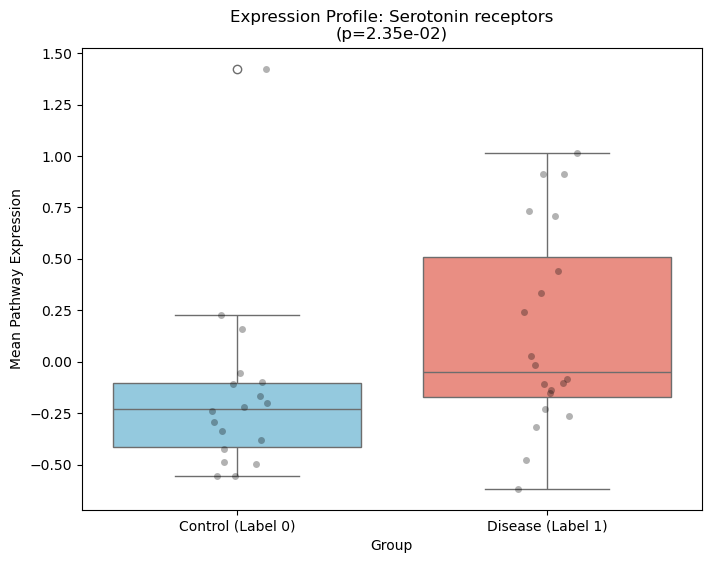

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# ---------------------------------------------------------
# 1. Configuration & File Paths
# ---------------------------------------------------------
# Path to the pathway-gene mapping file
MAPPING_FILE = "/mnt/disk1/data_jin/Pathway_MAML/data/Reactome/final/percentile90_min10_matched_combined_pathways.csv"
# Path to the gene expression matrix (transposed, with 'Label' column)
EXPRESSION_FILE = "/mnt/disk1/data_jin/Pathway_MAML/data/NCBI/ipf_ssc/second_filtered_combined_counts_transposed.tsv"

# The specific pathway name to analyze
TARGET_PATHWAY = "Serotonin receptors"

def analyze_pathway_expression():
    print(f"[INFO] Loading mapping file: {MAPPING_FILE}")
    try:
        df_map = pd.read_csv(MAPPING_FILE)
    except FileNotFoundError:
        print(f"[ERROR] Mapping file not found.")
        return

    # 1. Identify Genes in the Pathway
    # Extract the list of genes (IDs) belonging to the target pathway
    genes_in_pathway = df_map[df_map['Pathway'] == TARGET_PATHWAY]['ID'].unique().tolist()
    print(f"[INFO] Found {len(genes_in_pathway)} genes in pathway: '{TARGET_PATHWAY}'")
    
    if len(genes_in_pathway) == 0:
        print("[ERROR] No genes found. Please check the pathway name spelling.")
        return

    print(f"[INFO] Loading expression matrix: {EXPRESSION_FILE}")
    try:
        df_expr = pd.read_csv(EXPRESSION_FILE, sep='\t')
    except FileNotFoundError:
        print(f"[ERROR] Expression file not found.")
        return
    
    # 2. Filter for Available Genes (Intersection)
    # Only keep genes that exist in both the pathway definition and the expression dataset
    available_genes = [g for g in genes_in_pathway if g in df_expr.columns]
    print(f"[INFO] {len(available_genes)} genes are present in the expression matrix.")
    
    if len(available_genes) == 0:
        print("[ERROR] No matching genes found in the expression file.")
        return

    if 'Label' not in df_expr.columns:
        print("[ERROR] 'Label' column is missing in expression file.")
        return

    # 3. Split Groups (Label 1 = Disease, Label 0 = Control)
    group_disease = df_expr[df_expr['Label'] == 1][available_genes]
    group_control = df_expr[df_expr['Label'] == 0][available_genes]
    
    n_disease = len(group_disease)
    n_control = len(group_control)
    
    # 4. Calculate Representative Expression Score (Mean of genes per sample)
    scores_disease = group_disease.mean(axis=1)
    scores_control = group_control.mean(axis=1)
    
    mean_d = scores_disease.mean()
    mean_c = scores_control.mean()
    
    # 5. Statistical Test (Two-sided Mann-Whitney U)
    # Tests if the distributions of the two groups are significantly different
    u_stat, p_val = mannwhitneyu(scores_disease, scores_control, alternative='two-sided')
    
    # 6. Result Interpretation
    print("\n" + "=" * 80)
    print(f"Analysis Report: {TARGET_PATHWAY}")
    print(f"Sample Size    : Disease (n={n_disease}) vs Control (n={n_control})")
    print(f"Mean Expression: Disease = {mean_d:.4f} | Control = {mean_c:.4f}")
    print(f"Difference     : {mean_d - mean_c:.4f} (Disease - Control)")
    print(f"P-value        : {p_val:.4e}")
    print("=" * 80)
    
    print("\n[INTERPRETATION]")
    if p_val < 0.05:
        if mean_d > mean_c:
            # Case: Disease > Control
            print("RESULT: The actual expression level in the disease group is significantly HIGHER than in the control group.")
            print("   -> Biological Context: Consistent with pathogenic activation or compensatory upregulation.")
            print("   -> XAI Interpretation (if model said 'higher_in_label0'):")
            print("      The model likely used the 'absence' or 'low basal level' of this pathway in healthy samples")
            print("      as a key predictor for the Control class (Clean Room Hypothesis).")
        else:
            # Case: Disease < Control
            print("RESULT: The actual expression level in the disease group is significantly LOWER than in the control group.")
            print("   -> Biological Context: Consistent with loss of function or deficiency in disease.")
            print("   -> XAI Interpretation (if model said 'higher_in_label1'):")
            print("      The model likely utilized this 'deficiency' (low values) as a strong negative feature")
            print("      to predict the Disease class (Deficiency as Evidence).")
    else:
        # Case: No significant difference
        print("RESULT: No significant difference in mean expression between groups.")
        print("   -> The model may be detecting complex non-linear interactions or variance differences")
        print("      rather than simple up/down regulation.")

    # 7. Visualization
    plt.figure(figsize=(8, 6))
    plot_data = pd.DataFrame({
        'Mean Expression': np.concatenate([scores_control, scores_disease]),
        'Group': ['Control (Label 0)'] * len(scores_control) + ['Disease (Label 1)'] * len(scores_disease)
    })
    
    sns.boxplot(x='Group', y='Mean Expression', data=plot_data, palette=['skyblue', 'salmon'])
    sns.stripplot(x='Group', y='Mean Expression', data=plot_data, color='black', alpha=0.3, jitter=True)
    
    plt.title(f"Expression Profile: {TARGET_PATHWAY}\n(p={p_val:.2e})")
    plt.ylabel("Mean Pathway Expression")
    
    save_filename = "pathway_expression_analysis.png"
    plt.savefig(save_filename)
    print(f"\n[INFO] Boxplot saved as '{save_filename}'.")

if __name__ == "__main__":
    analyze_pathway_expression()

### Significant Biomrker Analysis

In [ ]:
import os
import pandas as pd

# 기준(f1)과 비교(f2) 폴더 경로 설정
f1_root = "/mnt/disk1/data_jin/Pathway_MAML/results/biomarker"               # Pathway_MAML biomarker
f2_root = "/mnt/disk1/data_jin/Pathway_MAML/results/biomarker_random_init"   # Pathweay_MLP biomarker

def list_disease_dirs(root):
    return [
        d for d in os.listdir(root)
        if os.path.isdir(os.path.join(root, d))
    ]

def load_large_paths(csv_path):
    """
    CSV에서 effect_size_magnitude == 'large' 인 Pathway만 set으로 반환
    CSV가 없거나 컬럼이 없으면 빈 set
    """
    if not os.path.isfile(csv_path):
        return set()
    df = pd.read_csv(csv_path)
    if "effect_size_magnitude" not in df.columns or "Pathway" not in df.columns:
        return set()
    df_large = df[df["effect_size_magnitude"] == "large"]
    return set(df_large["Pathway"].astype(str))

# 두 폴더에 모두 존재하는 질병만 비교
diseases_f1 = list_disease_dirs(f1_root)
diseases_f2 = list_disease_dirs(f2_root)
common_diseases = sorted(set(diseases_f1) & set(diseases_f2))

rows = []

for disease in common_diseases:
    f1_csv = os.path.join(f1_root, disease, "significant_pathways_labeled.csv")
    f2_csv = os.path.join(f2_root, disease, "significant_pathways_labeled.csv")

    large_f1 = load_large_paths(f1_csv)
    large_f2 = load_large_paths(f2_csv)

    inter = large_f1 & large_f2

    n_f1 = len(large_f1)
    n_f2 = len(large_f2)
    n_inter = len(inter)

    # f1이 f2에 얼마나 포함되는지: 교집합 / f1
    inclusion_f1_in_f2 = (n_inter / n_f1) if n_f1 > 0 else float("nan")

    # 보기 좋게 문자열로도 만들어 둠
    overlap_names = "; ".join(sorted(inter))

    rows.append({
        "disease": disease,
        "n_large_f1(biomarker)": n_f1,
        "n_large_f2(biomarker_random_init)": n_f2,
        "n_common(large_in_both)": n_inter,
        "inclusion_f1_in_f2": inclusion_f1_in_f2,
        "common_pathways": overlap_names,
    })
    
result_df = pd.DataFrame(rows).sort_values("disease").reset_index(drop=True)

out_path = "/mnt/disk1/data_jin/Pathway_MAML/results/biomarker_large_overlap_summary.csv"
result_df.to_csv(out_path, index=False)
out_path

result_df = pd.DataFrame(rows).sort_values("disease").reset_index(drop=True)
result_df


,disease,n_large_f1(biomarker),n_large_f2(biomarker_random_init),n_common(large_in_both),inclusion_f1_in_f2,common_pathways
0,HBV-HCC,188,146,93,0.494681,APC truncation mutants have impaired AXIN bind...
1,IgA_nephropathy,53,49,23,0.433962,"Cell death signalling via NRAGE, NRIF and NADE..."
2,cirrhosis,88,56,31,0.352273,Budding and maturation of HIV virion; Constitu...
3,idiopathic_pulmonary_fibrosis,95,77,41,0.431579,Aberrant regulation of mitotic exit in cancer ...
4,ipf_ssc,71,54,26,0.366197,Aberrant regulation of mitotic exit in cancer ...
